In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

file_path="/content/dutch-tweets-chunk0-1.csv"
print("Loading data...")

df=pd.read_csv(file_path,usecols=["latitude","longitude"])
print("cleaning data...")
df=df.dropna(subset=["latitude","longitude"])


df['latitude'] = df['latitude'].astype(str).str.replace(r'[()]', '', regex=True)
df['longitude'] = df['longitude'].astype(str).str.replace(r'[()]', '', regex=True)


df["latitude"]=pd.to_numeric(df["latitude"],errors="coerce")
df["longitude"]=pd.to_numeric(df["longitude"],errors="coerce")


df = df.dropna(subset=['latitude', 'longitude'])


print("cleaning data...")

df=df[(df["latitude"].between(50.75, 53.5))&
      (df["longitude"].between(3.3, 7.2))]


print(f"Total records loaded:{len(df)}")
map_center=[df["latitude"].mean(),
            df["longitude"].mean()]
HeatMap_map=folium.Map(location=map_center,zoom_start=7)
heat_data=df[["latitude","longitude"]].values.tolist()
print("Generating heatman...")
HeatMap(heat_data,radius=10,blur=15,max_zoom=6).add_to(HeatMap_map)
output_file="geo_heatmap_full.html"
HeatMap_map.save(output_file)
print(f"Heatmap saved as {output_file}")

Loading data...
cleaning data...
cleaning data...
Total records loaded:11725
Generating heatman...
Heatmap saved as geo_heatmap_full.html


In [ ]:
!pip install pandas torch transformers matplotlib seaborn wordcloud "ray[air]"

In [ ]:
import pandas as pd
import json
import re

df = pd.read_json('dutch_tweets_chunk0[1].json')

def clean_tweet(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['full_text'].apply(clean_tweet)

print("Data loaded and cleaned successfully!")
print(f"Number of tweets to analyze: {len(df)}")
print(df[['full_text', 'cleaned_text']].head())

Data loaded and cleaned successfully!
Number of tweets to analyze: 27019
                                           full_text  \
0  @pflegearzt @Friedelkorn @LAguja44 Pardon, wol...   
1  RT @grantshapps: Aviation demand is reduced du...   
2  RT @DDStandaard: De droom van D66 wordt werkel...   
3  RT @DDStandaard: De droom van D66 wordt werkel...   
4  De droom van D66 wordt werkelijkheid: COVID-19...   

                                        cleaned_text  
0     pardon wollte eigentlich das zitieren \n\nm...  
1  rt  aviation demand is reduced due to covid19 ...  
2  rt  de droom van d66 wordt werkelijkheid covid...  
3  rt  de droom van d66 wordt werkelijkheid covid...  
4  de droom van d66 wordt werkelijkheid covid19 s...  


In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="DTAI-KULeuven/robbert-v2-dutch-sentiment"
)

sample_size = 500
sample_texts = df['cleaned_text'].head(sample_size).tolist()
sentiments = sentiment_pipeline(sample_texts)

df_sample = df.head(sample_size).copy()
df_sample['sentiment'] = [result['label'].lower() for result in sentiments]
df_sample['sentiment_score'] = [result['score'] for result in sentiments]

print("\nSentiment Analysis Results (Sample):")
print(df_sample[['cleaned_text', 'sentiment', 'sentiment_score']].head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/875 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu



Sentiment Analysis Results (Sample):
                                        cleaned_text sentiment  \
0     pardon wollte eigentlich das zitieren \n\nm...  negative   
1  rt  aviation demand is reduced due to covid19 ...  negative   
2  rt  de droom van d66 wordt werkelijkheid covid...  positive   
3  rt  de droom van d66 wordt werkelijkheid covid...  positive   
4  de droom van d66 wordt werkelijkheid covid19 s...  positive   

   sentiment_score  
0         0.988716  
1         0.945199  
2         0.998209  
3         0.998209  
4         0.996762  


/tmp/ipython-input-18-1366973541.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


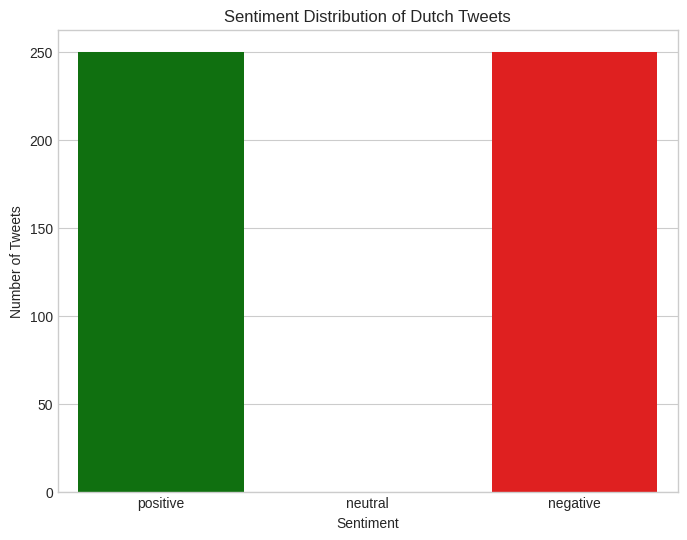

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(8, 6))
sns.countplot(
    x='sentiment',
    data=df_sample,
    order=['positive', 'neutral', 'negative'],
    palette={'positive': 'green', 'neutral': 'grey', 'negative': 'red'}
)
plt.title('Sentiment Distribution of Dutch Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

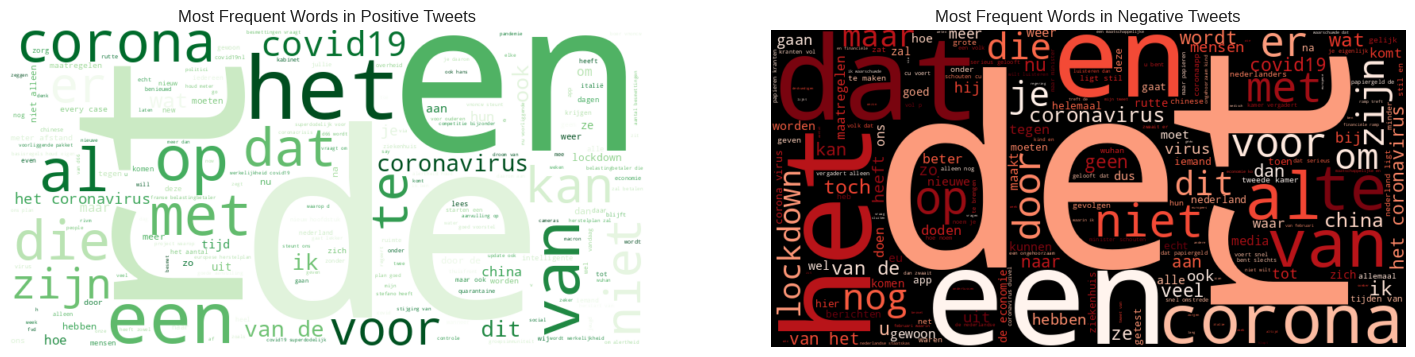

In [ ]:
from wordcloud import WordCloud

positive_text = " ".join(df_sample[df_sample['sentiment'] == 'positive']['cleaned_text'])
negative_text = " ".join(df_sample[df_sample['sentiment'] == 'negative']['cleaned_text'])

positive_wordcloud = WordCloud(background_color='white', colormap='Greens', width=800, height=400).generate(positive_text)
negative_wordcloud = WordCloud(background_color='black', colormap='Reds', width=800, height=400).generate(negative_text)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Most Frequent Words in Positive Tweets')
ax1.axis('off')

ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Most Frequent Words in Negative Tweets')
ax2.axis('off')

plt.show()